In [1]:
!pip install emoji transformers

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import re
from collections import Counter, defaultdict
import emoji
from collections import Counter
from tqdm.notebook import tqdm

import random
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer,BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv("/kaggle/input/emotion-detection-from-text/tweet_emotions.csv")
df

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [6]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

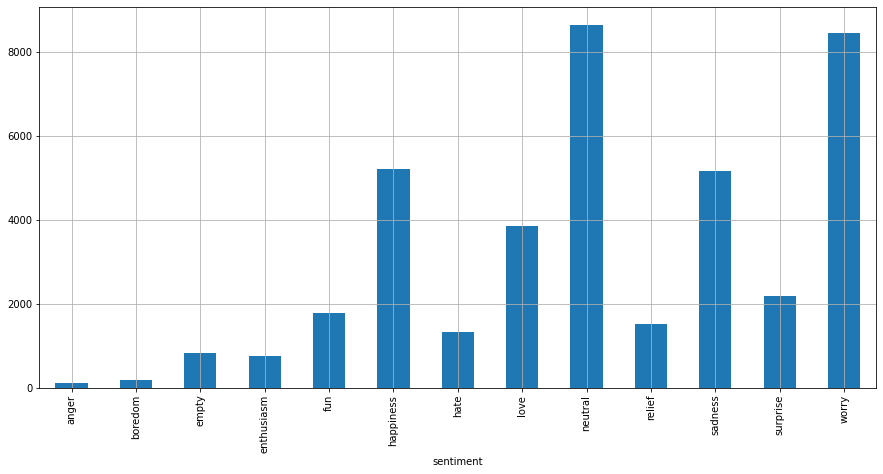

In [7]:
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)

In [8]:
from sklearn.utils import resample

sent = df.sentiment.unique()

max = 3
target_majority = df[df.sentiment==sent[max]]

#min_class = [0, 2, 5, 7, 8, 10, 11, 12]

for cl in range(13):
    train_minority = df[df.sentiment==sent[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=123)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 
#'''

anger         8638
relief        8638
boredom       8638
happiness     8638
hate          8638
fun           8638
love          8638
surprise      8638
worry         8638
enthusiasm    8638
sadness       8638
empty         8638
neutral       8638
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

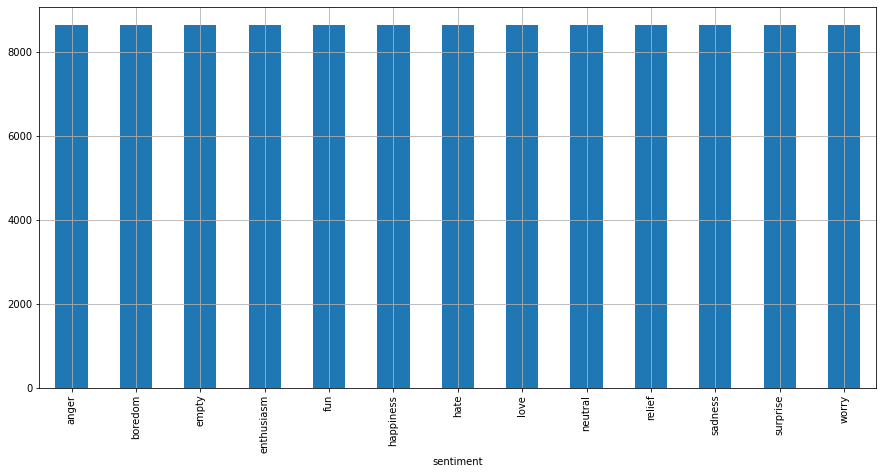

In [9]:
df = train_upsampled.sample(frac=1).reset_index(drop=True)
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)


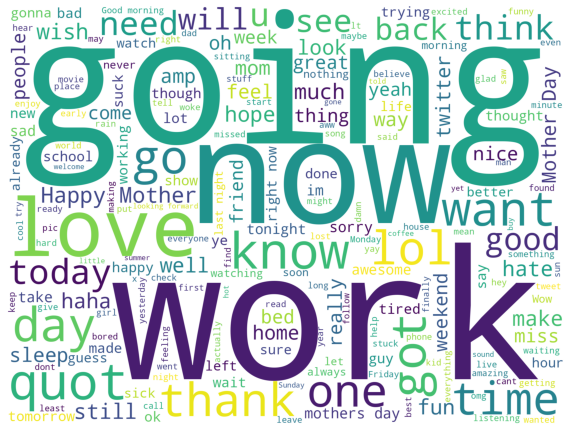

In [10]:
df_cloud = df[df['sentiment']=='neutral'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

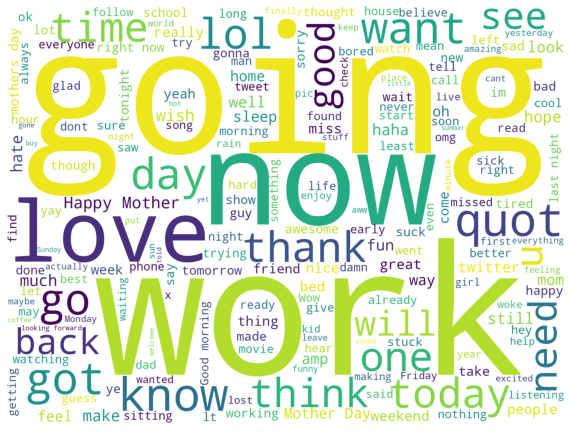

In [11]:
df_cloud = df[df['sentiment']=='happiness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

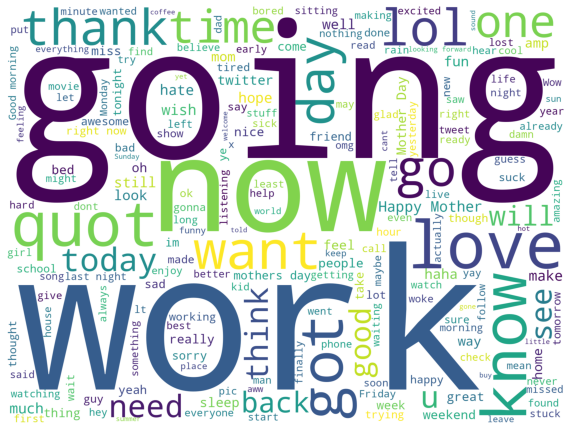

In [12]:
df_cloud = df[df['sentiment']=='worry'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

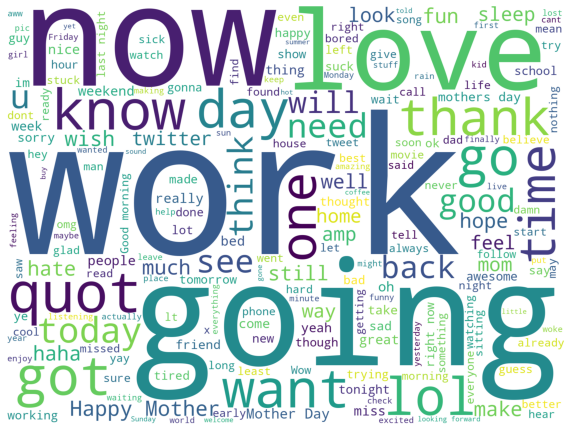

In [13]:
df_cloud = df[df['sentiment']=='sadness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)

In [15]:
sent

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [16]:
label

{'empty': 0,
 'sadness': 1,
 'enthusiasm': 2,
 'neutral': 3,
 'worry': 4,
 'surprise': 5,
 'love': 6,
 'fun': 7,
 'hate': 8,
 'happiness': 9,
 'boredom': 10,
 'relief': 11,
 'anger': 12}

In [17]:
df['label'] = df.sentiment.replace(label)
df.head()


,tweet_id,sentiment,content,label
0,1752224445,empty,Watching twilight and eating potato salad.,0
1,1962326416,anger,i hella wanted a sausage mcmuffin but when i g...,12
2,1961748103,hate,Today in the friendly game one asshole hit me ...,8
3,1695106767,neutral,@I_Wanna_Be Well who can argue with Gibbs and ...,3
4,1965974531,worry,@Lujee #3aaah mosh 3aref a facebook any more,4


In [18]:
from operator import itemgetter  

d = df.label.value_counts()
for key, value in sorted(d.items(), key = itemgetter(0), reverse = False):
    print(key, value)


0 8638
1 8638
2 8638
3 8638
4 8638
5 8638
6 8638
7 8638
8 8638
9 8638
10 8638
11 8638
12 8638


In [19]:
english_stopwords = set(stopwords.words("english"))
english_punctuations = string.punctuation

def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text

def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in english_stopwords]
    return ' '.join(filtered_sentence)

def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line = line.lower()
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')

    
    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in english_punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', english_punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [20]:
df.content = df.content.apply(cleaning_content)

In [21]:
df

,tweet_id,sentiment,content,label
0,1752224445,empty,watching twilight eating potato salad,0
1,1962326416,anger,hella wanted sausage mcmuffin gt breakfast,12
2,1961748103,hate,today friendly game one asshole hit knee lying...,8
3,1695106767,neutral,well argue gibbs win p finally someone knows g...,3
4,1965974531,worry,3aaah mosh 3aref facebook,4
...,...,...,...,...
112289,1957091327,sadness,morning hate mornings offensive,1
112290,1966096850,enthusiasm,hopefully discover soap opera tweets,2
112291,1753466539,relief,marking going ok far b far relieved looks like...,11
112292,1963331407,hate,delayed flight san diego las vegas delayed fli...,8


In [22]:
df.drop('tweet_id', inplace=True, axis=1)


In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
df

,sentiment,content,label
0,empty,watching twilight eating potato salad,0
1,anger,hella wanted sausage mcmuffin gt breakfast,12
2,hate,today friendly game one asshole hit knee lying...,8
3,neutral,well argue gibbs win p finally someone knows g...,3
4,worry,3aaah mosh 3aref facebook,4
...,...,...,...
112289,sadness,morning hate mornings offensive,1
112290,enthusiasm,hopefully discover soap opera tweets,2
112291,relief,marking going ok far b far relieved looks like...,11
112292,hate,delayed flight san diego las vegas delayed fli...,8


In [25]:
content = ' '.join(list(df.content))
words = content.split(' ')

In [26]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.content)
corpus[:10]


['watching',
 'twilight',
 'eating',
 'potato',
 'salad',
 'hella',
 'wanted',
 'sausage',
 'mcmuffin',
 'gt']

In [27]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'day': 8183,
 'good': 6113,
 'get': 5747,
 'like': 5581,
 'go': 5263,
 'work': 5097,
 'going': 4551,
 'got': 4509,
 'today': 4479,
 'im': 4374}

<AxesSubplot:xlabel='sentiment'>

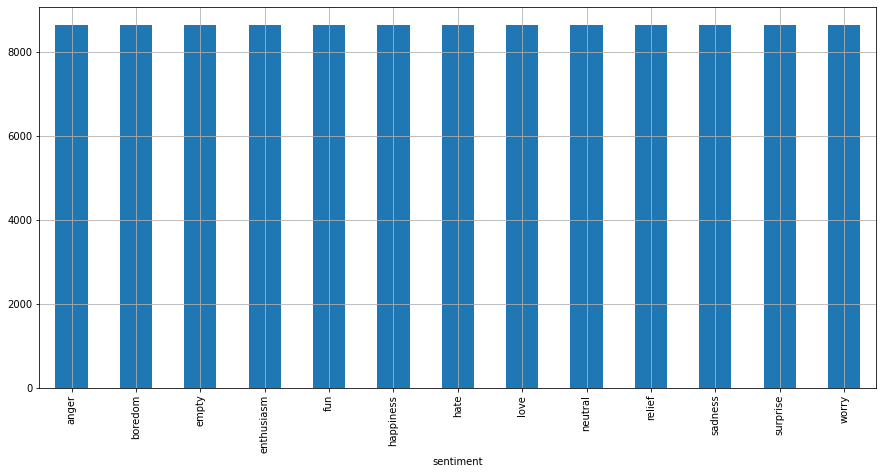

In [28]:
df.groupby('sentiment')['content'].count().plot.bar(figsize=(15,7),grid=True)

In [29]:
max_len = 100

In [30]:
class SentiDataset(Dataset):
    def __init__(self, contents, labels, tokenizer, max_len):
        self.contents = contents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.contents)
  
    def __getitem__(self, item):
        content = str(self.contents[item])
        label = self.labels[item]
        
        # Tokenizing the texts, while also including special tokens 
        # for start and end of the text, as well as padding
        encoding = self.tokenizer.encode_plus(
          content,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # We return here the data as Pytorch Tensor
        )

        return {
          'content': content,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [31]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=random.seed(42))

print("The size of training set is : " + str(df_train.shape[0]))
print("The size of validation set is : " + str(df_val.shape[0]))

The size of training set is : 89835
The size of validation set is : 22459


In [32]:
df['data_type'] = ['not_set']*df.shape[0]


In [33]:
df

,sentiment,content,label,data_type
0,empty,watching twilight eating potato salad,0,not_set
1,anger,hella wanted sausage mcmuffin gt breakfast,12,not_set
2,hate,today friendly game one asshole hit knee lying...,8,not_set
3,neutral,well argue gibbs win p finally someone knows g...,3,not_set
4,worry,3aaah mosh 3aref facebook,4,not_set
...,...,...,...,...
112289,sadness,morning hate mornings offensive,1,not_set
112290,enthusiasm,hopefully discover soap opera tweets,2,not_set
112291,relief,marking going ok far b far relieved looks like...,11,not_set
112292,hate,delayed flight san diego las vegas delayed fli...,8,not_set


In [34]:
df.loc[df_train.index.to_numpy(), 'data_type'] = 'train'
df.loc[df_val.index.to_numpy(), 'data_type'] = 'val'

In [35]:
df

,sentiment,content,label,data_type
0,empty,watching twilight eating potato salad,0,val
1,anger,hella wanted sausage mcmuffin gt breakfast,12,train
2,hate,today friendly game one asshole hit knee lying...,8,train
3,neutral,well argue gibbs win p finally someone knows g...,3,train
4,worry,3aaah mosh 3aref facebook,4,train
...,...,...,...,...
112289,sadness,morning hate mornings offensive,1,train
112290,enthusiasm,hopefully discover soap opera tweets,2,train
112291,relief,marking going ok far b far relieved looks like...,11,train
112292,hate,delayed flight san diego las vegas delayed fli...,8,train


In [36]:
df.groupby(['sentiment', 'label', 'data_type']).count()

content
sentiment  label data_type         
anger      12    train         6884
                 val           1754
boredom    10    train         6892
                 val           1746
empty      0     train         6948
                 val           1690
enthusiasm 2     train         6931
                 val           1707
fun        7     train         6878
                 val           1760
happiness  9     train         6916
                 val           1722
hate       8     train         6844
                 val           1794
love       6     train         6974
                 val           1664
neutral    3     train         6888
                 val           1750
relief     11    train         6934
                 val           1704
sadness    1     train         6882
                 val           1756
surprise   5     train         6908
                 val           1730
worry      4     train         6956
                 val           1682

In [37]:
def generate_dataloader(df, tokenizer, max_len, batch_size):
    ds = SentiDataset(
        contents=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

In [38]:
batch_size = 16
train_dataloader = generate_dataloader(df_train, tokenizer, max_len ,batch_size)
val_dataloader = generate_dataloader(df_val, tokenizer, max_len ,batch_size)

data = next(iter(train_dataloader))
print(data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

{'content': ['fooled', 'dying read hate england', 'one week till exam block', 'good morning twitters soooo tired really need 2 stay twitter lol shit taking life lol', 'meant seeing lot tonight tix ran', 'prom party tonight', 'soooo bored aint funny', 'watched mall cop funny bad guess kinda wish still worked movie theater', 'excellent looks like twitterific competition', 'im really bored anthony senior board shit im hungry cold', 'ok mean disrespect fuck', 'dont', 'ordered new computer unfortunately get end june', 'wowzer deep stuff cis probably give earning potential', 'going outro peace', 'gonna shower take nap tired'], 'input_ids': tensor([[  101, 25857,   102,  ...,     0,     0,     0],
        [  101,  5996,  3191,  ...,     0,     0,     0],
        [  101,  2028,  2733,  ...,     0,     0,     0],
        ...,
        [  101, 10166,  6290,  ...,     0,     0,     0],
        [  101,  2183,  2041,  ...,     0,     0,     0],
        [  101,  6069,  6457,  ...,     0,     0,     0

In [39]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)


torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [40]:
bert = BertModel.from_pretrained("bert-base-uncased")


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [41]:
model_outs = bert(
  input_ids=data['input_ids'], 
  attention_mask=data['attention_mask']
)

pooled_output = model_outs[1]
last_hidden_state = model_outs[0]

In [42]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Adding drop out, keeping 90% of the last neurons of the raw BERT model
        self.drop = nn.Dropout(p=0.1)
        # The last linear layer for multiclass classification
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    # Forward propagation function
    def forward(self, input_ids, attention_mask):
        model_outs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        last_hidden_state = model_outs[0]
        pooled_output = model_outs[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [43]:
model = SentimentClassifier(len(sent))

# Running the classifier on GPU
model = model.to(device)

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [45]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0912, 0.0824, 0.0985, 0.0802, 0.0792, 0.1027, 0.1080, 0.0481, 0.0595,
         0.0622, 0.0946, 0.0328, 0.0605],
        [0.0886, 0.0880, 0.0906, 0.0795, 0.0654, 0.1044, 0.0958, 0.0491, 0.0660,
         0.0753, 0.0815, 0.0405, 0.0752],
        [0.0934, 0.0684, 0.1125, 0.0669, 0.0754, 0.0864, 0.0806, 0.0923, 0.0706,
         0.0541, 0.0966, 0.0280, 0.0747],
        [0.0712, 0.0686, 0.1331, 0.0876, 0.0670, 0.1106, 0.0680, 0.1012, 0.0456,
         0.0601, 0.0739, 0.0432, 0.0698],
        [0.0897, 0.1025, 0.0846, 0.0653, 0.0591, 0.1125, 0.0976, 0.0563, 0.0501,
         0.0729, 0.1074, 0.0412, 0.0609],
        [0.0725, 0.0769, 0.1130, 0.0959, 0.0648, 0.0896, 0.0705, 0.0858, 0.0610,
         0.0635, 0.0688, 0.0434, 0.0943],
        [0.0757, 0.0899, 0.1147, 0.0785, 0.0753, 0.1029, 0.0851, 0.0762, 0.0481,
         0.0728, 0.0669, 0.0404, 0.0733],
        [0.0721, 0.0720, 0.1117, 0.0943, 0.0656, 0.1208, 0.0695, 0.0812, 0.0528,
         0.0560, 0.0672, 0.0333, 0.1035],
        [0.1037,

In [46]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  correct_bias=False)
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*epochs)

In [47]:
loss_fn = nn.CrossEntropyLoss().to(device)


In [48]:
# Computing multiclass precision for the outputs of the model
def compute_precision(outputs, labels):
  op = outputs.cpu()
  la = labels.cpu()
  _, preds = torch.max(op, dim=1)
  # We choose 'weighted' averaging of the precision of each label because it takes into account the imbalance of labels in our tweets dataset
  # other viable averaging methods are 'micro'
  return torch.tensor(precision_score(la, preds, average='weighted'))

In [49]:
def train(model, train_dataloader,optimizer,scheduler):

        # Reset tracking variables at the beginning of each epoch
        precision, correct_predictions, batch_counts = 0, 0, 0
        losses = []

        # Put the model into the training mode
        model.train()

  
        # For each batch of training data...
        for d in train_dataloader:
              batch_counts +=1
              # Load batch to GPU
              input_ids = d["input_ids"].to(device)
              attention_mask = d["attention_mask"].to(device)
              labels = d["labels"].to(device)

              outputs = model(input_ids=input_ids,attention_mask=attention_mask)
              
              _, preds = torch.max(outputs, dim=1)
              
              # Compute loss and accumulate the loss values

              loss = loss_fn(outputs, labels)

              correct_predictions += torch.sum(preds == labels)
              losses.append(loss.item())
              precision +=  compute_precision(outputs, labels)
            
              loss.backward()

              # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
              # Update parameters and the learning rate  
              optimizer.step()
              scheduler.step()
              optimizer.zero_grad()
          # Accuracy, loss, precision
        return correct_predictions.double() / len(df_train), np.mean(losses), precision/batch_counts

In [50]:
def eval(model, valid_dataloader, loss_fn, device):
    model = model.eval()


    correct_predictions , precision ,batch_counts = 0,0,0
    losses = []

    with torch.no_grad():
        for d in valid_dataloader:
            batch_counts += 1

            # Preparing inputs
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Running inference using the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, labels)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == labels)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 
            precision += compute_precision(outputs,labels)

            losses.append(loss.item())
    # Accuracy, loss, precision 
    return correct_predictions.double() / len(df_val), np.mean(losses), precision/batch_counts 

In [51]:
!nvidia-smi

Wed Dec  1 17:09:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |   2559MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
history = defaultdict(list)
b_accuracy = 0

for epoch in range(epochs):
  
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 20)

  train_acc, train_loss, train_preci = train(
        model,
        train_dataloader,    
        optimizer, 
        scheduler,
      )
  print(f"Train : Loss {train_loss}, Accuracy : {train_acc}, Precision : {train_preci}")

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_precision'].append(train_preci)

  val_acc, val_loss, val_preci = eval(
        model,
        val_dataloader,
        loss_fn, 
        device, 
      )

  print(f'Val : Loss :{val_loss}, Accuracy : {val_acc}, Precision : {val_preci}')  
  print()

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_precision'].append(val_preci)
  
  if val_acc > b_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    b_accuracy = val_acc

Epoch 1/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 1.5935223617780878, Accuracy : 0.46678911337452, Precision : 0.49231893914621727


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.9677637083684107, Accuracy : 0.6759428291553498, Precision : 0.7090279415800275

Epoch 2/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.7870908881377559, Accuracy : 0.7366505259642678, Precision : 0.7737624692575223


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.6562519979177632, Accuracy : 0.7882808673582974, Precision : 0.8136495352641198

Epoch 3/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.49053016045028786, Accuracy : 0.8370456948850671, Precision : 0.8674326315566302


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.5679561794901988, Accuracy : 0.8331181263635958, Precision : 0.8528325744471571

Epoch 4/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.34202221521372944, Accuracy : 0.8891968609116715, Precision : 0.9129766145104492


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.5456440305026206, Accuracy : 0.8470101073066477, Precision : 0.8656134471238625



In [53]:
b_accuracy

tensor(0.8470, device='cuda:0', dtype=torch.float64)

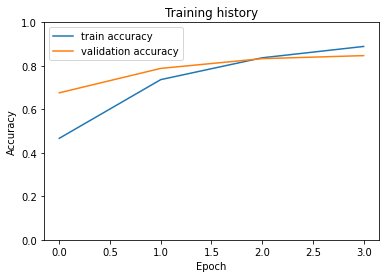

In [54]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);